# generate tip logs using the Luo-Rudy model for a folder of initial conditions
Tim Tyree<br>
1.21.2021

In [1]:
from lib.my_initialization import *
from lib.utils.utils_traj import *
import trackpy
from scipy import stats
from lib.utils.operari import *

%autocall 1
%load_ext autoreload
%autoreload 2
# awareness&chill

Automatic calling is: Smart


In [ ]:
1

In [2]:
darkmode=True
if darkmode:
    #make plots in darkmode
    import seaborn as sns
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# generate tip logs for the Luo-Rudy model

In [3]:
# ic = search_for_filename()
# ic=search_for_file()
ic="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic001.33.npz"
# ic="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-300x300/ic-in/ic300x300.0.3.npz"
# ic="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-600x600/ic-in/ic600x600.0.3.npz"

In [4]:
base_folder=os.path.dirname(os.path.dirname(ic))
os.chdir(base_folder)
L=200
tmax_sec=30
print(base_folder)

/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR


In [5]:
#initialize filesystem if not already initialized
cwd=os.getcwd()
# base_folder   = '/'+os.path.join(*cwd.split('/')[:-1])
# base_folder=f"{nb_dir}/Data/initial-conditions-suite-3-LR"
V_threshold=-40#mV
K_o=5.4#50#3.8
diffCoef=0.0005
dt=0.025
DT=0.1
save_every_n_frames=int(DT/dt)

results_folder=f'param_qu_tmax_{tmax_sec}_Ko_{K_o}_diffCoef_{diffCoef}_dt_{dt*save_every_n_frames:.3f}_Vthresh_{V_threshold}'
# param_fn = 'param_set_8_og.json'
try:
    init_filesystem_bd(base_folder,
                      results_folder=results_folder,
                      subfolder_list=None)
except FileExistsError:
    print('new file system not initialized.')

new file system not initialized.


In [6]:
#reset in out if ic-in is empty of npz files
enable_reset_in_out=False
if enable_reset_in_out:
    os.chdir(base_folder)
    def is_npz(s): return s[-4:]=='.npz'
    retval = [fn for fn in os.listdir('ic-in') if is_npz(fn)]
    if len(retval)==0:
        os.rename('ic-in','ic-in2')
        os.rename('ic-out','ic-in')
        os.rename('ic-in2','ic-out')
        print('ic was reset')

In [7]:
npartitions=6

In [8]:
#get all .npz files in the file's directory
input_fn_lst=get_all_files_matching_pattern(file=ic, trgt='.npz')
len(input_fn_lst)

120

In [9]:
from lib.routines.generate_tip_logs_LR_model_cy import *
# from lib.routines.generate_tip_logs_LR_model_cy import *
from lib.routines.kwargs_LR_model_cy import get_kwargs

def routine(ic):
#     kwargs = get_kwargs(ic)   
    kwargs = get_kwargs(ic, results_folder=results_folder)#,param_fn=param_fn)
    kwargs['V_threshold'] =  V_threshold#mV
    kwargs['mode'] =  'LR'
    kwargs['h']=dt
#     kwargs['V_threshold'] =  .4#mV
#     kwargs['mode'] =  'FK'
#     kwargs['dt']=0.025
    kwargs['save_every_n_frames']= 1#40
    kwargs['tmin']=100
    kwargs['diffCoef'] = diffCoef
    kwargs['dsdpixel'] = 0.025#ds/width#0.025#
#     kwargs['h']=0.1# kwargs['h']=0.01 for ds_1_param_set_8 for stability
    kwargs['tmax_sec'] = tmax_sec #maximum time to be integrated in seconds
    kwargs['tmax']     = tmax_sec*10**3
    kwargs['K_o']=K_o#TODO: expose K_o to this level if it should be varied extensively
    kwargsout = generate_tip_logs_from_ic(ic, **kwargs)
    #     print(f"completed birth_death_rates_from_ic: {ic}")
    #     print(f"csv of spiral tip data stored in: {kwargs['completed_ic_dir']}")
#     return os.path.basename(ic)
    return kwargsout#['data_dir_log']#output location
generate_tip_logs_from_ic

<function lib.routines.generate_tip_logs_LR_model_cy.generate_tip_logs_from_ic(initial_condition_dir, h, tmax, V_threshold, dsdpixel, diffCoef, tmin_early_stopping, save_every_n_frames, round_output_decimals, printing, logging, asserting, saving, data_dir_log, completed_ic_dir, print_log_dir, Ca_i_initial=0.0002, Vmax=45.0, Vmin=-75.0, **kwargs)>

In [10]:
# kwargs = get_kwargs(ic, results_folder=results_folder)#,param_fn=param_fn)
# kwargs
# get_kwargs(ic, results_folder=results_folder)
# ds/200

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


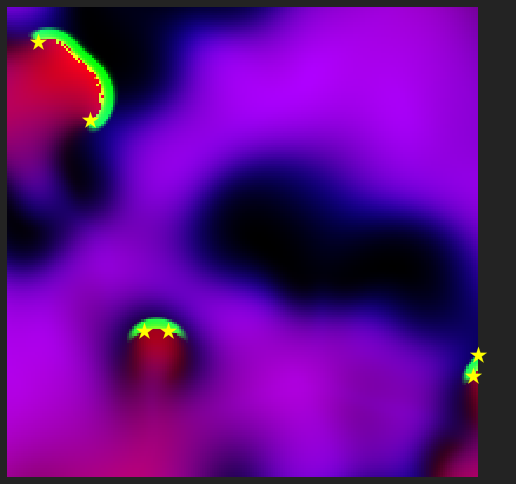

In [11]:
#test the V_threshold value
j=1
level1 = V_threshold
t=-999
level2 = 0.
ic=input_fn_lst[j]
txt=load_buffer(ic)#input_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]

img=inVc[...,0]
dimgdt=dVcdt[...,0]
compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
print(len(list(dict_out['x'])))
fig=show_buffer_LR(txt)
axs=fig.get_axes()
ax=axs[0]
ax.scatter(dict_out['x'],dict_out['y'],s=300,c='yellow',marker='*')
plt.show()

In [12]:
# # #test the routine on 1 file
# input_fn=ic#'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/ic007.33.npz' 
# kwgs=routine(input_fn)

In [ ]:
#all CPU version
b = db.from_sequence(input_fn_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(b)
print(f"run time for generating birth-death rates from file_name_list: {time.time()-start:.2f} seconds.")
beep(10)

# etc

### Estimated runtime per ic-suite of initial conditions (cpu) is very slow, but the analysis pipeline can update after each trial if I wanted.
- is 2 days without saving any data<br>

integrating to t=10 ms takes 11 seconds of runtime<br>
thus, integrating to t=10 s should take 11*10**3 seconds of runtime, <br>
which is ~ 3 hours per trial per cpu core<br>
thus, `the runtime to run N=171 trials on 10 cpu cores is expected to be 171/10*3/24 ~ 2 days`
- is 3.5 days with saving data at a very early stopping time<br>

integrating by t=10 ms takes 6 minutes of runtime with saving 1 time per millisecond<br>
thus, integrating to t=10 s should take 6*10**3 minutes of runtime with the saving I've been doing, <br>
which is 6*10**3/60 ~ 100 hours per trial per cpu core<br>
with save_every_n_frames=20 (once per 2 ms) and integrating to tmax=1 second would cut this down to 5 hours per trial
^this would take 5*171/10/24 = 3.5 days per ic-suite

In [31]:
from inspect import getsource
print(getsource(load_buffer))

def load_buffer(data_dir):
	if data_dir[-4:]=='.npy':
		txt = np.load(data_dir)
		return txt
	elif data_dir[-4:]=='.npz':
		txt = np.load(data_dir)
		txt = txt[txt.files[0]]  #only take the first buffer because there's typically one
		return txt
	else:
		print(f"\tWarning: Failed to load {data_dir}.")
		raise Exception(f"\tWarning: Failed to load {data_dir}.")



### Ways to make the pipeline faster
- remove the unnecessary feature measurements (just make them optional via some new kwarg!)
- learn GPUDirect Storage (avoid: very time consuming!)
- scale to open science grid (prereq: test/dev function taking an ic to an msd csv (or a diffcoeff csv!))

## TODO: profile the runtime of the save block of code that records spiraltips.  Can this be streamed/saved directly to a file to see a speedup?
- note that after simplifying, computing dict_out takes <40ms...  


In [61]:
R = 8.3145  # J/(mol * °K) universal gas constant
T = 273.15+37#°K physiologically normal body temperature 37°C
F = 96485.3321233100184 # C/mol faraday's constant
# R=8.315
# T=310.15
# F=96490.
rtoverffull=R*T/F
rtoverf=rtoverffull#0.02650

In [83]:
# write(6,*)rtoverffull,rtoverf
xk0=7#2.85#K_o#,5.4#7. higher K_o should give shorter APD#
# c     gx1=0.282*2.837*sqrt(5.4/xk0)
# c modified to:
gx1=0.423*2.837*np.sqrt(5.4/xk0)
gk1=0.6047*np.sqrt(xk0/5.4)
pr=0.01833
xna0=140.
xnai=18.
xki=145.
vx1=1000.*rtoverf*np.log((xk0+pr*xna0)/(xki+pr*xnai))
vx1
#wj's code used vx1=77.6mV for K_o=5.4
#luo used vx1=-87.94 for K_o=2.85
#let's try K_o=7

-72.71743403953546